# 讀取資料

In [3]:
from matplotlib import pyplot as plt
import numpy as np
from ccuhdf import get_path, VNAxDC
# data = np.flip(data, axis=1).T
# data = data.T
data_filepath = get_path('.hdf5', title = 'open .hdf5 file contains MEASURMENT data.')
print('measurement data file path:\n', data_filepath)

measurement data file path:
 C:/Users/user/Desktop/QEL專案/MIRROR/Hsu_mirror(source)/274ms only x2=160.01mm (no x1)_II_debackground.hdf5


# Plot整張圖

file:C:/Users/user/Desktop/QEL專案/MIRROR/Hsu_mirror(source)/274ms only x2=160.01mm (no x1)_II_debackground.hdf5


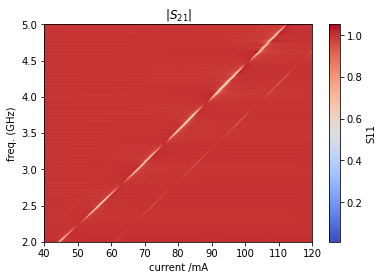

In [4]:
data = VNAxDC.get_data(data_filepath)
info = VNAxDC.get_info(data_filepath, print_info=False)
fig, ax, extent, flipfunc = VNAxDC.get_ploting_objs(info)
 
data_0 = flipfunc(data)

'''def contrast(data):

    if abs(data)>1:
    
'''
print(f'file:{data_filepath}')

im = ax.imshow(abs(data_0), cmap='coolwarm', aspect='auto',extent= extent)
plt.colorbar(im).set_label(info['VNA - trace'] )



plt.xlabel('current /mA')
plt.ylabel('freq. (GHz)')
plt.title(r'$|S_{21}|$')
#plt.text(56,3.1,f'(file:{data_filepath})', ha='center')
plt.show()




In [5]:
s = data_0.shape
print(s)

print(info)

(3001, 401)
{'VNA - trace': 'S11', 'VNA - # of points': 3001, 'VNA - # of traces': 401, 'VNA - start frequency': 2000000000.0, 'VNA - stop frequency': 5000000000.0, 'DC1 - sweep': False, 'DC1 - current': 0.04, 'DC2 - sweep': True, 'DC2 - start current': 0.04, 'DC2 - stop current': 0.12, 'DC2 - # of steps': 401}


# 切個Traces(確實)

(3001, 401)


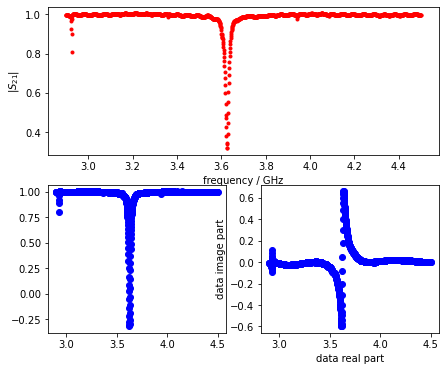

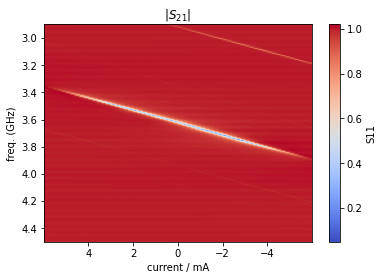

In [14]:
def get_fslice(info, frange):
    f0 = info['VNA - start frequency']
    f1 = info['VNA - stop frequency']
    nf = info['VNA - # of points']
    i0 = info['DC2 - start current']
    i1 = info['DC2 - stop current']
    ni = info['DC2 - # of steps']
    step = (f1 - f0) / nf
    step_i = (i1 - i0) / ni
    
    current = np.linspace(i0, i1, ni)
    frq = np.linspace(f0, f1, nf)
    return slice(int( (frange[0] - f0) // step - 1), 
                 int( (frange[1] - f0) // step + 1)) , frq, step_i

strat_f, stop_f = 2.9e+9, 4.5e+9
screen , frq , step_i = get_fslice(info, [strat_f, stop_f])  #3.5e+9,6e+9
trace_no = 210

#screen = slice(None)
s = data_0.shape
print(s)


plt.figure(figsize= (7,6))

plt.subplot(211)
#Vmax = np.maximum(abs(data[:, trace_no]), 0.3)
plt.plot(frq[screen]/1e+9, abs( data[:, trace_no:trace_no+1])[screen], 'r .')
#plt.ylim(0,0.08)
plt.xlabel( 'frequency / GHz')
plt.ylabel('$|S_{21}|$')
#plt.title(f'Trace No.{trace_no}')
plt.subplot(223)
plt.plot(frq[screen]/1e+9, np.real(data[:, trace_no:trace_no+1])[screen],'bo')
plt.subplot(224)
plt.plot(frq[screen]/1e+9, np.imag(data[:, trace_no:trace_no+1])[screen],'bo')
plt.xlabel('data real part')
plt.ylabel('data image part')
plt.title

d_trace = 30
extent = [ d_trace*1e3*step_i, -1e3*d_trace*step_i, max(frq[screen]/1e+9), min(frq[screen]/1e+9)]

fig, ax = plt.subplots(figsize=(6, 4))
#plt.imshow(abs(data_0), cmap='coolwarm', aspect='auto',)
im = ax.imshow(abs(data[:,trace_no-d_trace:trace_no+d_trace ])[screen], cmap='coolwarm', aspect='auto', extent = extent)
plt.colorbar(im).set_label(info['VNA - trace'] )
plt.xlabel('current / mA')
plt.ylabel('freq. (GHz)')
plt.title(r'$|S_{21}|$')
plt.show()


## find dip point as the centra of the figure

In [21]:
def get_dip(s_data):
    dip_p = np.argmin(s_data)
    return dip_p


# 單一trace fiting

Fitted Parameters:
>> omega_m = 3.625768951680211
>> alpha = 0.0064792141467991966
>> kappa = 0.011486252383880787


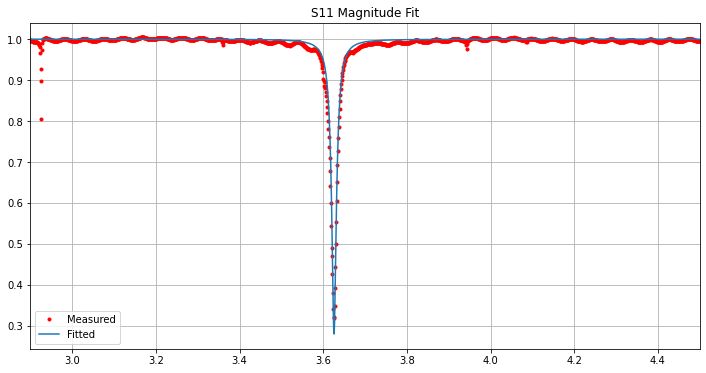

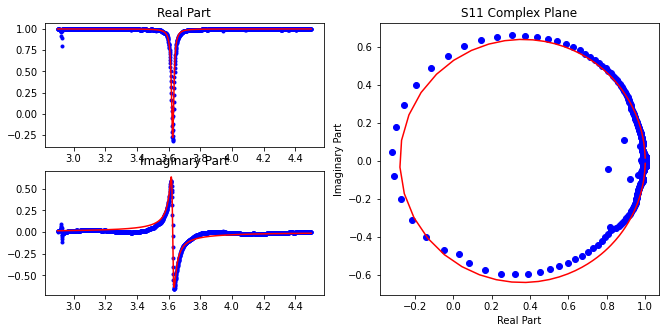

In [25]:
import numpy as np
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt
import inspect

# Constants
pi = np.pi

def s11(omega, omega_m, alpha, kappa):
    """
    Computes the S11 parameter based on given frequency (omega) and system parameters.
    """
    Gamma = (alpha + kappa) / 2
    s11_value = 1 - (kappa / (Gamma - 1j * (omega - omega_m)))
    return np.hstack([s11_value.real, s11_value.imag])

def fit_s11(frequencies, measured_s11, initial_guess):
    """
    Fits the S11 function to measured data.
    """
    param_names = list(inspect.signature(s11).parameters.keys())[1:]
    
    coeffs, cov = curve_fit(
        s11,
        frequencies,
        ydata=np.hstack([measured_s11.real, -1*measured_s11.imag]),
        bounds=([0, 0, 0], [100, 100, 100]),
        method='dogbox',
        p0=initial_guess,
    )
    
    print('Fitted Parameters:')
    for name, value in zip(param_names, coeffs):
        print(f">> {name} = {value}")
    
    return coeffs

def plot_results(frequencies, measured_s11, fitted_s11):
    """
    Plots the measured and fitted S11 magnitude.
    """
    midpoint = fitted_s11.shape[-1] // 2
    real_part = fitted_s11[:midpoint]
    imag_part = fitted_s11[midpoint:]
    sum_complex = real_part + 1j * imag_part
    
    plt.figure(figsize=(12, 6))
    plt.plot(frequencies, abs(measured_s11), 'r .', label='Measured')
    plt.plot(frequencies, abs(sum_complex), label='Fitted')
    plt.xlim(np.min(frequencies), np.max(frequencies))
    plt.legend()
    plt.grid()
    plt.title("S11 Magnitude Fit")
    plt.show()
    
    # Real and Imaginary parts
    plt.figure(figsize=(11, 5))
    plt.subplot(221)
    plt.plot(frequencies, measured_s11.real, 'b.')
    plt.plot(frequencies, real_part, 'r-')
    plt.title('Real Part')
    
    plt.subplot(223)
    plt.plot(frequencies, -1*measured_s11.imag, 'b.')
    plt.plot(frequencies, imag_part, 'r-')
    plt.title('Imaginary Part')
    
    plt.subplot(122)
    plt.plot(measured_s11.real, measured_s11.imag, 'bo')
    plt.plot(real_part, imag_part, 'r-')
    plt.xlabel('Real Part')
    plt.ylabel('Imaginary Part')
    plt.title("S11 Complex Plane")
    
    plt.show()

def switch_mode(mode, frequencies, measured_s11, initial_guess):
    """
    Switch between coefficient setting mode and fitting mode.
    """
    if mode == "set":
        print("Initial Coefficients:")
        for name, value in zip(["omega_m", "alpha", "kappa"], initial_guess):
            print(f">> {name} = {value}")
        s11_fit = s11(frequencies, *initial_guess)
        plot_results(frequencies, measured_s11, s11_fit)
    elif mode == "fit":
        coeffs = fit_s11(frequencies, measured_s11, initial_guess)
        s11_fit = s11(frequencies, *coeffs)
        plot_results(frequencies, measured_s11, s11_fit)
    else:
        print("Invalid mode. Use 'set' or 'fit'.")

def main():
    """
    Main execution function.
    """
    global frq, data, screen
    f_used = frq[screen] / 1e9
    s11_used = data[screen, trace_no: trace_no+1].ravel()
    
    initial_guess = np.array([3.6, 0.0042, 0.0063])  # Initial parameter estimates
    
    # Switch mode here: "set" for initial coefficients, "fit" for fitting
    mode = "fit"
    switch_mode(mode, f_used, s11_used, initial_guess)

main()
